In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
tqdm.pandas()
# instantiating GOManager object and downloading Gene Ontology data
from notebooks.tair_ids_to_goslims.go_manager import GOManager
go_mngr = GOManager()

/tmp/go.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms
/tmp/goslim_generic.obo: fmt(1.2) rel(go/2024-09-08/subsets/goslim_generic.owl) 206 Terms


#### Path to your file containing your tair ids (one tair id by line)

In [3]:
file = '/path/to/your/file'

#### Parsing Tair IDs from file and mapping them to Uniprot IDs

In [4]:
df = pd.read_csv(file, names=['tair_id'])
tair_ids = [tair_id.split('.')[0] for tair_id in df['tair_id'].tolist()]

In [5]:
tair_ids_to_uniprot_ids = go_mngr.get_uniprot_ids(tair_ids)

#### Getting GO terms and GOSLIM terms from tair IDs

In [6]:
df = pd.DataFrame.from_records(tair_ids_to_uniprot_ids).rename(columns={'from': 'tair_id', 'to': 'uniprot_id'})
df['go_terms'] = df['uniprot_id'].progress_apply(go_mngr.get_go_terms)

100%|██████████| 942/942 [02:48<00:00,  5.61it/s]


In [7]:
df1 = df.groupby('tair_id')['go_terms'].apply(go_mngr.merge_go_term_list).reset_index()
df1[['goslim_terms', 'goslim_names']] = df1.apply(lambda row: go_mngr.get_goslim_mappings(row),axis=1, result_type='expand')

Could not get goslim from GO:0070469
Could not get goslim from GO:0070469
Could not get goslim from GO:0052747
Could not get goslim from GO:0102483
Could not get goslim from GO:0006490
Could not get goslim from GO:0006490
Could not get goslim from GO:0045330
Could not get goslim from GO:0102229
Could not get goslim from GO:1901528
Could not get goslim from GO:0030744


In [8]:
for namespace in GOManager.GOTERM_CATEGORIES:
    df1[[f'{namespace}_goslim_terms', f'{namespace}_goslim_names']] = df1.apply(
        lambda row: go_mngr.get_specific_goslim_mappings(row, namespace=namespace), axis=1, result_type='expand')

#### Displaying plots

/home/olivier/repositories/misc_bioinfo/notebooks/tair_ids_to_goslims/go_manager.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[subplot_index].set_xticklabels(axes[subplot_index].get_xticklabels(), rotation=45, ha='right')
/home/olivier/repositories/misc_bioinfo/notebooks/tair_ids_to_goslims/go_manager.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[subplot_index].set_xticklabels(axes[subplot_index].get_xticklabels(), rotation=45, ha='right')
/home/olivier/repositories/misc_bioinfo/notebooks/tair_ids_to_goslims/go_manager.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[subplot_index].set_xticklabels(axes[subplot_index].get_xticklabels(), rotation=45, ha='right')


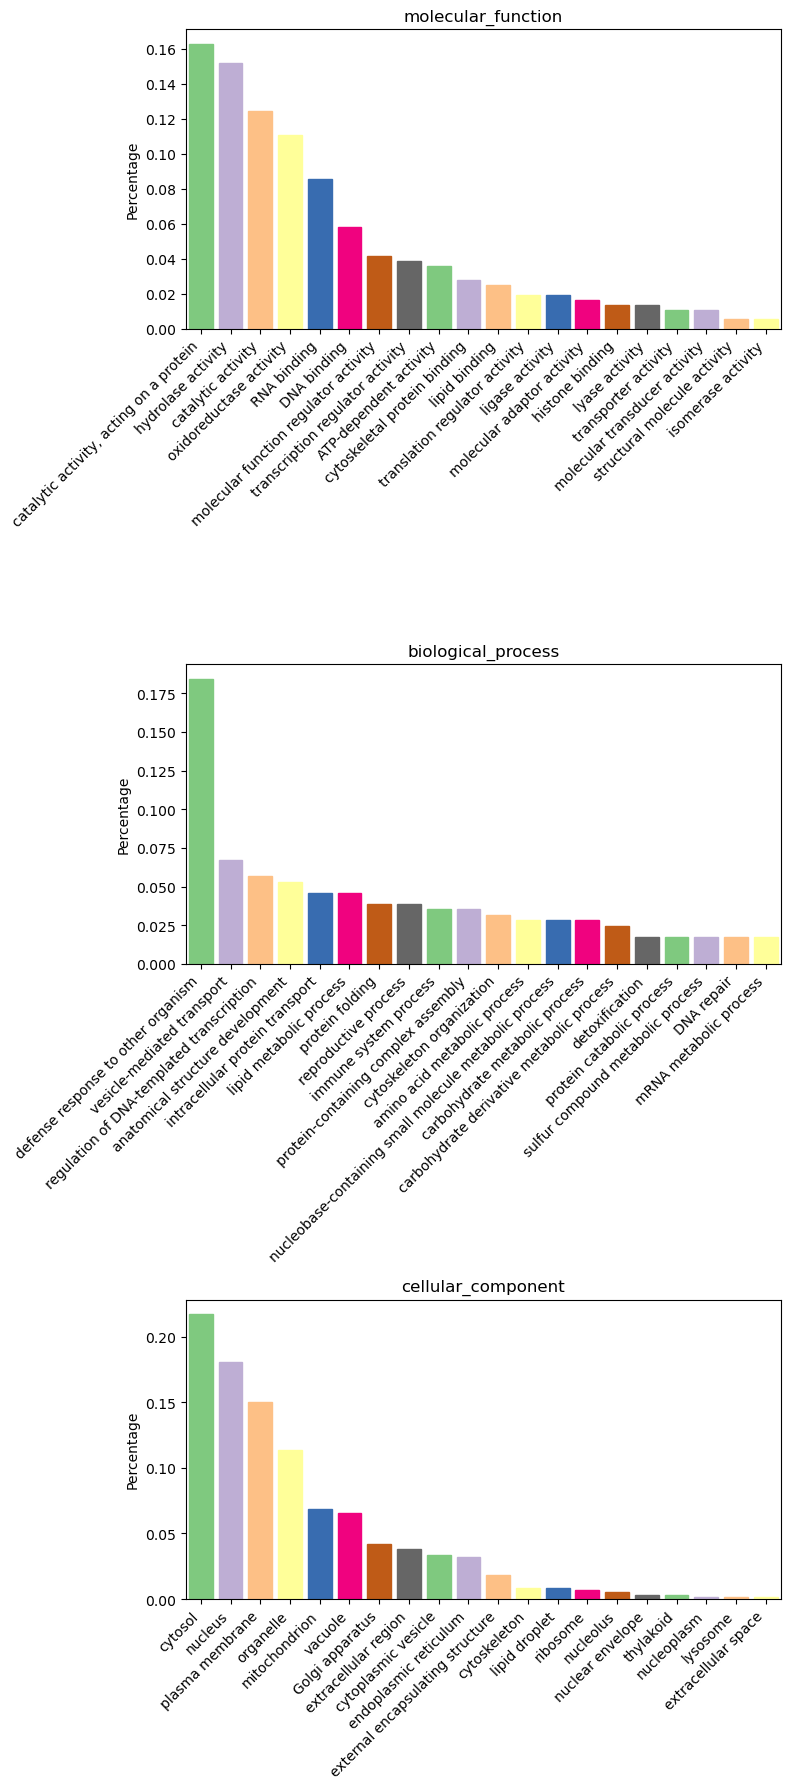

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))
for i, namespace in enumerate(GOManager.GOTERM_CATEGORIES):
    goslims_lists = df1[f'{namespace}_goslim_terms'].tolist()
    go_mngr.plot_counts(axes, namespace, goslims_lists, subplot_index=i)
plt.tight_layout()
plt.show()

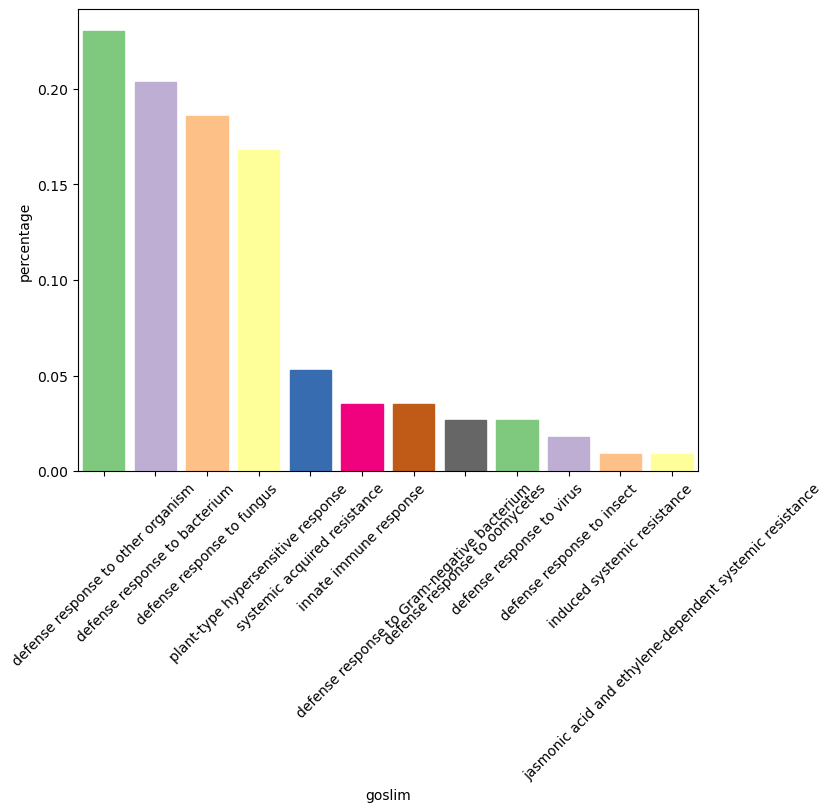

In [10]:
goslim_name = 'defense response to other organism'
func = partial(go_mngr.keep_go_term_corresponding_to_goslim, goslim_name=goslim_name)
filtered_goterms = df1['go_terms'].apply(func)

plt.figure(figsize=(8, 6))
specific_go_terms = filtered_goterms.tolist()
go_mngr.plot_one_count(specific_go_terms)
plt.xticks(rotation=45)
plt.show()